In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
# display plots in this notebook
%matplotlib inline

# set display defaults
plt.rcParams['figure.figsize'] = (10, 10)        # large images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatmap

from dataloader import *
from model import *
from util_sample import *
import os.path

### Load data:

In [2]:
directory = 'data/'
filename = 'coords.csv'
config = {}
config['seq_len'] = 60
config['batch_size'] = 64
config['overlap_rate'] = 0.0
config['coords'] = 3

dl = DataLoad(directory, filename)
dl.load_data(config['seq_len'], config['overlap_rate'], verbose = False)
dl.split_train_test(0.8)

data = dl.data
X_test = np.transpose(data['X_test'], [0,2,1])

max z is 458
31998 train samples and 8000 test samples


### Display some test data:

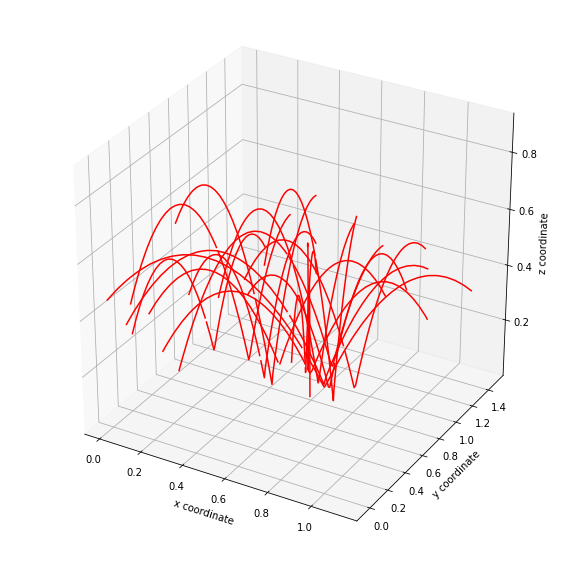

In [3]:
fig = plt.figure()
ax = fig.gca(projection='3d')
for i in range(30):
    seq = X_test[i]
    ax.plot(seq[0,:], seq[1,:], seq[2,:],'r')
ax.set_xlabel('x coordinate')
ax.set_ylabel('y coordinate')
ax.set_zlabel('z coordinate')
plt.show()

### Load the pretrain model:

In [4]:
g = tf.Graph()
pretrained_graph_def = tf.GraphDef()
pretrained_graph_path = './data/export-graph.pb'

with open(pretrained_graph_path, 'rb') as f:
    pretrained_graph_def.ParseFromString(f.read())
    _ = tf.import_graph_def(pretrained_graph_def, name='')

Load some ops in the graph:

In [5]:
session = tf.Session()

placeholder_x = session.graph.get_tensor_by_name("Test/Model/Input_data:0")
initial_state_c_0 = session.graph.get_tensor_by_name("Test/Model/zeros:0")
initial_state_h_0 = session.graph.get_tensor_by_name("Test/Model/zeros_1:0")
initial_state_c_1 = session.graph.get_tensor_by_name("Test/Model/zeros_2:0")
initial_state_h_1 = session.graph.get_tensor_by_name("Test/Model/zeros_3:0")
initial_state = []
initial_state.append((initial_state_c_0, initial_state_h_0))
initial_state.append((initial_state_c_1, initial_state_h_1))
final_state_c_0 = session.graph.get_tensor_by_name("Test/Model/RNN/multi_rnn_cell_59/cell_0/lstm_cell/add_3:0")
final_state_h_0 = session.graph.get_tensor_by_name("Test/Model/RNN/multi_rnn_cell_59/cell_0/lstm_cell/mul_5:0")
final_state_c_1 = session.graph.get_tensor_by_name("Test/Model/RNN/multi_rnn_cell_59/cell_1/lstm_cell/add_3:0")
final_state_h_1 = session.graph.get_tensor_by_name("Test/Model/RNN/multi_rnn_cell_59/cell_1/lstm_cell/mul_5:0")
final_state = []
final_state.append((final_state_c_0, final_state_h_0))
final_state.append((final_state_c_1, final_state_h_1))
test_outputs = []
test_outputs.append(session.graph.get_tensor_by_name("Test/Model/MDN/split_1:0"))
test_outputs.append(session.graph.get_tensor_by_name("Test/Model/MDN/split_1:1"))
test_outputs.append(session.graph.get_tensor_by_name("Test/Model/MDN/split_1:2"))
test_outputs.append(session.graph.get_tensor_by_name("Test/Model/MDN/Exp_1:0"))
test_outputs.append(session.graph.get_tensor_by_name("Test/Model/MDN/Exp_2:0"))
test_outputs.append(session.graph.get_tensor_by_name("Test/Model/MDN/Exp_3:0"))
test_outputs.append(session.graph.get_tensor_by_name("Test/Model/MDN/Tanh:0"))
test_outputs.append(session.graph.get_tensor_by_name("Test/Model/MDN/Mul:0"))

### Sample some sequence with our model:

some parameters:

- predict_len: length of the sequence the model has to predict.
- sl_pre: number of data points you feed to the model before it predict.
- bias: a large bias will make the predicted trajectory less diversity.

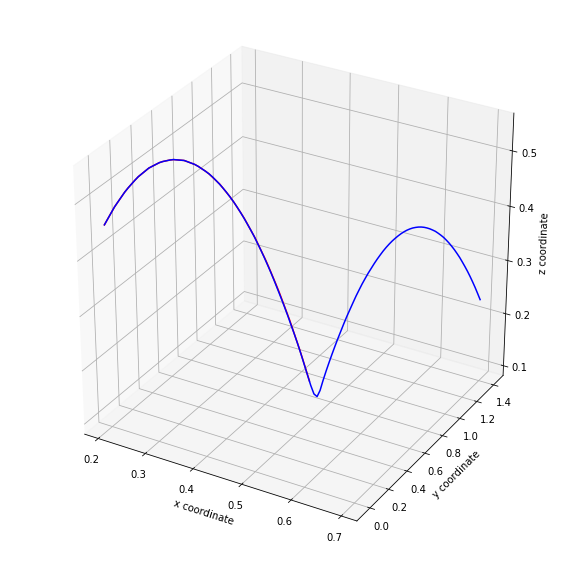

In [6]:
sample_more(session, placeholder_x, initial_state, final_state, test_outputs, config, X_test[0], predict_len=120, sl_pre=30, bias=2.0)

### Predict with less data points fed:

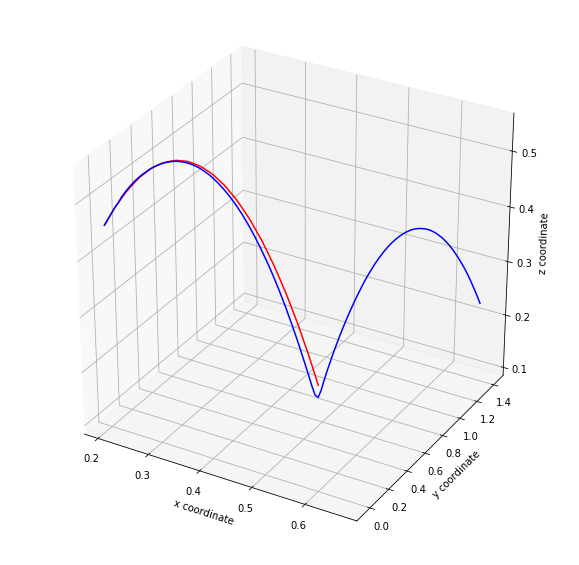

In [7]:
sample_more(session, placeholder_x, initial_state, final_state, test_outputs, config, X_test[0], predict_len=120, sl_pre=4, bias=2.0)